<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/master/notebooks/HWRActiveTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Transfer Learning for Handwriting Recognition

This notebook contains code to combine active and transfer learning into a
cohesive framework. The hope is to allow for new handwriting datasets to be
fitted quickly.

In this notebook, we will start the process of fitting the Washington dataset
when our list of pre-trained models were trained on the IAM, Rimes, and Bentham
datasets.

## Dependencies

First, let's import our dependencies such as Tensorflow, numpy, etc.

In [1]:
import os

import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.constraints as kc
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## Download Datasets and Pre-trained Models

In [ ]:
# IAM HWR LINE LEVEL MODEL
# ID: 1LmI0kZLGCwE3uD34AbTsmOilvRaWLoIW
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LmI0kZLGCwE3uD34AbTsmOilvRaWLoIW' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1LmI0kZLGCwE3uD34AbTsmOilvRaWLoIW" -O iam_hwr_line_level_model.zip && rm -rf /tmp/cookies.txt
!unzip iam_hwr_line_level_model.zip
!rm iam_hwr_line_level_model.zip

# RIMES HWR LINE LEVEL MODEL
# ID: 1MJgNMILauGNfw8fQpEj00pJc6iPDG1uE
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MJgNMILauGNfw8fQpEj00pJc6iPDG1uE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1MJgNMILauGNfw8fQpEj00pJc6iPDG1uE" -O rimes_hwr_line_level_model.zip && rm -rf /tmp/cookies.txt
!unzip iam_hwr_line_level_model.zip
!rm iam_hwr_line_level_model.zip

# BENTHAM HWR LINE LEVEL MODEL
# ID: 1rBCjaLGX0kXjeF4Gwg6JjE3PC5Z_QDq2
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rBCjaLGX0kXjeF4Gwg6JjE3PC5Z_QDq2' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1rBCjaLGX0kXjeF4Gwg6JjE3PC5Z_QDq2" -O bentham_hwr_line_level_model.zip && rm -rf /tmp/cookies.txt
!unzip iam_hwr_line_level_model.zip
!rm iam_hwr_line_level_model.zip

# WASHINGTON HWR LINE LEVEL MODEL
# ID: 10ia9GA1j0KY48CvQRUds2c-nbi1AeQAm
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=10ia9GA1j0KY48CvQRUds2c-nbi1AeQAm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=10ia9GA1j0KY48CvQRUds2c-nbi1AeQAm" -O washington_hwr_line_level_model.zip && rm -rf /tmp/cookies.txt
!unzip iam_hwr_line_level_model.zip
!rm iam_hwr_line_level_model.zip


# IAM HWR LINE LEVEL DATASET
# ID: 1ProJyrkE9NhflpYG0nQTfp-ZSvKLyVS1
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ProJyrkE9NhflpYG0nQTfp-ZSvKLyVS1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ProJyrkE9NhflpYG0nQTfp-ZSvKLyVS1" -O iam_hwr_line_level.zip && rm -rf /tmp/cookies.txt
!unzip iam_hwr_line_level.zip
!rm iam_hwr_line_level.zip

# RIMES HWR LINE LEVEL DATASET
# ID: 1baqdK4RJuxvlPErxkFipYaK1-5-SpEww
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1baqdK4RJuxvlPErxkFipYaK1-5-SpEww' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1baqdK4RJuxvlPErxkFipYaK1-5-SpEww" -O rimes_hwr_line_level.zip && rm -rf /tmp/cookies.txt
!unzip rimes_hwr_line_level.zip
!rm rimes_hwr_line_level.zip

# BENTHAM HWR LINE LEVEL DATASET
# ID: 1rFyNkYCkaMG9Mo3d8AFXaLe1fh6Hm3nF
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rFyNkYCkaMG9Mo3d8AFXaLe1fh6Hm3nF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1rFyNkYCkaMG9Mo3d8AFXaLe1fh6Hm3nF" -O bentham_hwr_line_level.zip && rm -rf /tmp/cookies.txt
!unzip bentham_hwr_line_level.zip
!rm bentham_hwr_line_level.zip
!rm -r __MACOSX

# WASHINGTON HWR LINE LEVEL DATASET
# ID: 10WLliclnhq3NnEjrHaNcGvrAnrafg94T
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=10WLliclnhq3NnEjrHaNcGvrAnrafg94T' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=10WLliclnhq3NnEjrHaNcGvrAnrafg94T" -O washington_hwr_line_level.zip && rm -rf /tmp/cookies.txt
!unzip washington_hwr_line_level.zip
!rm washington_hwr_line_level.zip

In [11]:
!ls

bentham_hwr_line_level	  iam_model		washington_hwr_line_level
iam_hwr_line_level	  rimes_hwr_line_level
iam_hwr_line_level_model  sample_data


In [41]:
!mv iam_hwr_line_level_model/ iam_model/

In [10]:
model.load_weights('iam_model/run1')

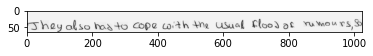

tf.Tensor(
[[0.99219644 0.9987124  0.9790725  0.999913   0.9991856  0.99433386
  0.6873795  0.99914014 0.998611   0.99946994 0.95614207 0.99768484
  0.9856639  0.99937266 0.97124046 0.9984666  0.99887186 0.69754905
  0.9811871  0.9994947  0.99893314 0.9872751  0.9992449  0.9930715
  0.8866467  0.5776214  0.7860524  0.9997595  0.9976036  0.9977137
  0.9998386  0.8917285  0.76713103 0.8918675  0.99835473 0.59225166
  0.9939766  0.94296485 0.8877005  0.99602073 0.99090827 0.99815506
  0.9996499  0.999353   0.9996418  0.9980209  0.9998479  0.9989095
  0.99695873 0.93216056 0.9403406  0.977958   0.9901833  0.9854785
  0.99872464 0.9984674  0.9633972  0.9982942  0.9987697  0.7167892
  0.99638534 0.9977895  0.98076564 0.8714543  0.99942446 0.9936819
  0.9996197  0.9988005  0.9986577  0.9333749  0.9757857  0.9958405
  0.99679106 0.9834552  0.99991953 0.9867736  0.9996972  0.9997031
  0.99954814 0.99209094 0.9959254  0.9996271  0.93837804 0.8732678
  0.9815105  0.9739353  0.41885766 0.99997866 

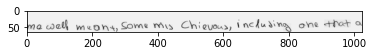

tf.Tensor(
[[0.99992585 0.9222655  0.9978034  0.9979315  0.939628   0.9754876
  0.9849954  0.4792418  0.9956483  0.9997379  0.9995852  0.9944431
  0.9995708  0.79195416 0.9996433  0.99777454 0.748743   0.98992515
  0.98694766 0.99991596 0.9852527  0.9990061  0.9937483  0.9925073
  0.9984738  0.99689025 0.99376017 0.9961261  0.99768996 0.9948862
  0.9927012  0.9039982  0.7172193  0.8120581  0.9534945  0.77754784
  0.94675285 0.99938524 0.9953023  0.8132974  0.9979488  0.9999893
  0.7442533  0.9996723  0.9975311  0.9985286  0.6799718  0.92594707
  0.9981433  0.9842679  0.99678504 0.85005397 0.9703822  0.8886754
  0.99531615 0.8810318  0.6281013  0.9957801  0.997227   0.52810866
  0.55387217 0.99923754 0.957645   0.99061817 0.7528645  0.9993531
  0.79013455 0.9993316  0.99799216 0.9982768  0.9998841  0.9984768
  0.99876666 0.5308     0.9998964  0.99772435 0.96102375 0.7933008
  0.9886868  0.99905044 0.9991636  0.95848674 0.7297539  0.99874926
  0.99789387 0.9958495  0.9955604  0.9118412  

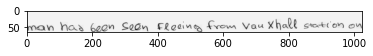

tf.Tensor(
[[0.99974865 0.9518518  0.99787104 0.99984777 0.99855655 0.8863352
  0.99934906 0.99860317 0.9979837  0.99889165 0.62110806 0.9797544
  0.86464715 0.99548906 0.9789357  0.9997009  0.9997584  0.93148
  0.99982077 0.99939895 0.992334   0.98582447 0.9925444  0.9959751
  0.9986829  0.9996469  0.9963761  0.9892406  0.99872166 0.8597144
  0.99953663 0.9983139  0.9992494  0.99982685 0.72337776 0.98656076
  0.64578384 0.9919338  0.9999391  0.9989133  0.997401   0.98647654
  0.9819857  0.9993191  0.99394834 0.99954826 0.9999558  0.8161927
  0.99269813 0.93486166 0.32685706 0.9999523  0.9980597  0.99323
  0.9996854  0.7179607  0.99924445 0.9623346  0.5323955  0.999627
  0.94364357 0.9990734  0.9985183  0.99892753 0.92010075 0.9390423
  0.92273176 0.9951298  0.99041826 0.9903808  0.9990552  0.9811584
  0.9942948  0.995168   0.999871   0.9807978  0.99833435 0.90939426
  0.9997601  0.99991846 0.77131647 0.9940848  0.73284405 0.9115328
  0.9994697  0.99945647 0.9880256  0.9999386  0.88839

In [16]:
char2idx = get_char2idx(DEFAULT_CHARS)
idx2char = get_idx2char(DEFAULT_CHARS)

dataset = get_encoded_dataset_from_csv('iam_hwr_line_level/iam_validation1.tsv', char2idx, 128, (64, 1024))

model = FlorRecognizer(len(DEFAULT_CHARS) + 1)
model.load_weights('iam_hwr_line_level_model/run1')

for img, label in dataset.take(3):
    output = model(tf.expand_dims(img, 0))
    output = tf.nn.softmax(output)
    prediction = tf.squeeze(tf.argmax(output, 2))
    plt.imshow(tf.squeeze(img), cmap='gray')
    plt.pause(0.01)
    print(tf.reduce_max(output, 2))
    print(prediction)
    print('Prediction', idxs_to_str(prediction, idx2char))
    print('Label:', idxs_to_str(label, idx2char, merge_repeated=False))

## Load the data

Here are a few functions to help us load our data into a format compatible with
Tensorflow

In [2]:
# The default list of characters used in the recognition model
DEFAULT_CHARS = " !\"#%&'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz{|}£¤§°²ÀÉàâçèéêëîôùûœſ€⊥𐌰𐌳𐌴𐌵𐌸𐌺𐌻𐌼𐌾𐍆𐍈"
# The default list of non-punctuation characters needed for the word beam search decoding algorithm
DEFAULT_NON_PUNCTUATION = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz£¤§°²ÀÉàâçèéêëîôùûœſ€⊥𐌰𐌳𐌴𐌵𐌸𐌺𐌻𐌼𐌾𐍆"
# The default list of punctuation characters needed for hte word beam search decoding algorithm
DEFAULT_PUNCTUATION = " !\"#%&'()*+,-./0123456789:;<=>?[]_{|}"

In [3]:
def str_charset_to_lists(charset):
    """
    Turns string containing all desired characters into list of chars and indices. This is required for mapping
    between integer and char representations for use in the recognition model.

    :param charset: charset as string of chars to be represented in model.
    """
    chars = list(charset)
    indices = list(range(1, len(chars) + 1))
    return chars, indices


def get_char2idx(charset):
    """
    A tensorflow lookup table is created and returned which allows us to encode word transcriptions on the fly
    in the tf.data api. A standard python dictionary won't work when tensorflow is running in graph mode. This
    function will return a lookup table to convert between chars and indices.

    :param charset: string containing all desired characters to be represented
    :return: A tensorflow lookup table to convert characters to integers
    """
    chars, indices = str_charset_to_lists(charset)

    char2idx = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(chars, dtype=tf.string),
            values=tf.constant(indices, dtype=tf.int64),
            key_dtype=tf.string,
            value_dtype=tf.int64
        ),
        default_value=0,
        name='char2idx_lookup'
    )

    return char2idx


def get_idx2char(charset):
    """
    A tensorflow lookup table is created and returned which allows us to encode word transcriptions on the fly
    in the tf.data api. A standard python dictionary won't work when tensorflow is running in graph mode. This
    function will return a lookup table to convert between indices and chars.

    :param charset: string containing all desired characters to be represented.
    :return: A tensorflow lookup table to convert integers to characters
    """
    chars, indices = str_charset_to_lists(charset)

    idx2char = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(indices, dtype=tf.int64),
            values=tf.constant(chars, dtype=tf.string),
            key_dtype=tf.int64,
            value_dtype=tf.string
        ),
        default_value='',
        name='idx2char_lookup'
    )

    return idx2char


def pad_or_truncate(t, sequence_size=128):
    """
    Pad or truncate a tensor to a fixed sequence length. Works for use in the tf.data api in graph mode.

    :param t: The tensor to pad or truncate
    :param sequence_size: The final sequence length of the tensor
    :return:
    """
    dim = tf.size(t)
    return tf.cond(tf.equal(dim, sequence_size), lambda: t,
                   lambda: tf.cond(tf.greater(dim, sequence_size), lambda: tf.slice(t, [0], [sequence_size]),
                                   lambda: tf.concat([t, tf.zeros(sequence_size - dim, dtype=tf.int64)], 0)))


def merge_repeating_values(t):
    """
    Merge repeating indices/characters in a tensor. Utilizes only tf.* functions which makes it
    usable in graph mode.

    :param t: The tensor to have repeated indices/characters merged
    :return: A new tensor with repeating values merged
    """
    t2 = tf.roll(tf.pad(t, [[0, 1]], constant_values=-1), -1, 0)[:tf.size(t)]
    not_equal = tf.math.not_equal(t, t2)
    indices = tf.where(not_equal)
    return tf.reshape(tf.gather(t, indices), [-1])


def str_to_idxs(string, char2idx, sequence_size):
    """
    Perform the actual lookup to convert a string to its integer representation. This function also performs
    padding according to the given sequence size. Works for use in the tf.data api in graph mode.

    :param string: The string to be converted
    :param char2idx: The tf lookup table
    :param sequence_size: The final sequence length
    :return: The converted string now in its integer representation
    """
    idxs = tf.map_fn(lambda char: char2idx.lookup(char), tf.strings.unicode_split(string, 'UTF-8'), dtype=tf.int64)
    return pad_or_truncate(idxs, sequence_size=sequence_size)


def idxs_to_str(idxs, idx2char, merge_repeated=True):
    """
    Perform the actual lookup to convert an integer to its string representation.
    Works for use in the tf.data api in graph mode.

    :param idxs: The idxs to be converted
    :param idx2char: The tf lookup table
    :param merge_repeated: Bool indicating whether or not to merge repeating values in the idx tensor
    :return: The converted idxs now in its string representation
    """
    if merge_repeated:
        idxs = merge_repeating_values(idxs)

    string = tf.map_fn(lambda idx: idx2char.lookup(idx), idxs, dtype=tf.string)
    string = tf.strings.reduce_join(string)
    return tf.strings.strip(string)


def str_to_idxs_batch(batch, char2idx, sequence_size=128):
    """
    Perform the same function as str_to_idxs, except a batch of strings are given as input

    :param batch: A batch of strings as tensor, list, or numpy array
    :param char2idx: The tf lookup table
    :param sequence_size: The final sequence length of each string
    :return: The converted strings now in its integer representation
    """
    return tf.map_fn(lambda string: str_to_idxs(string, char2idx, sequence_size=sequence_size), batch,
                     dtype=tf.int64)


def idxs_to_str_batch(batch, idx2char, merge_repeated=True):
    """
    Perform the same function as idxs_to_str, except a batch of idxs are given as input

    :param batch: A batch of idxs as tensor, list, or numpy array
    :param idx2char: The tf lookup table
    :param merge_repeated: Bool indicating whether or not to merge repeating values in the idx tensor
    :return: The converted idxs now in its string representation
    """
    return tf.map_fn(lambda idxs: idxs_to_str(idxs, idx2char, merge_repeated=merge_repeated), batch,
                     dtype=tf.string)


def img_resize_with_pad(img_tensor, desired_size, pad_value=255):
    """
    The standard tf.image.resize_with_pad function does not allow for specifying the pad value,
    so we create a function with that capability here. Aspect ratio will be preserved.

    :param img_tensor: The image tensor to be resized and padded
    :param desired_size: The desired size (height, width)
    :param pad_value: The value to pad the tensor with
    """
    img_size = tf.shape(img_tensor)

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = desired_size[0] / desired_size[1]

    if img_ratio >= desired_ratio:
        # Solve by height
        new_height = desired_size[0]
        new_width = int(desired_size[0] // img_ratio)
    else:
        new_height = int(desired_size[1] * img_ratio)
        new_width = desired_size[1]
        # Solve by width

    resized_img = tf.image.resize(img_tensor, (new_height, new_width), method=tf.image.ResizeMethod.BICUBIC)

    pad_height = desired_size[0] - new_height
    pad_width = desired_size[1] - new_width

    img_padded = tf.pad(resized_img, [[pad_height, 0], [0, pad_width], [0, 0]], constant_values=pad_value)

    return img_padded


def read_and_encode_image(img_path, img_size=(64, 1024)):
    """
    Used by both encode_img_and_transcription (training) and encode_img_with_name (inference). This method
    simply loads the image given a file path and performs the necessary encoding/resizing/transposing that
    is necessary for use on the recognition model.

    :param img_path: The path to the desired image
    :param img_size: The size of the image after resizing/padding
    :return: The encoded image in its tensor/integer representation
    """
    img_bytes = tf.io.read_file(img_path)
    img = tf.image.decode_image(img_bytes, channels=1, expand_animations=False)
    img = img_resize_with_pad(img, img_size)
    img = tf.image.per_image_standardization(img)

    return img


def encode_img_and_transcription(img_path, transcription, char2idx, sequence_size=128, img_size: tuple = (64, 1024)):
    """
    The actual function to map image paths and string transcriptions to its tensor/integer representation.

    :param img_path: The path to the desired image
    :param transcription: The transcription of the image in integer form
    :param char2idx: The tf lookup table
    :param sequence_size: The final sequence length for transcriptions
    :param img_size: The size of the image after resizing/padding
    :return: The image and transcription in their tensor/integer representations.
    """
    img = read_and_encode_image(img_path, img_size=img_size)
    line = str_to_idxs(transcription, char2idx, sequence_size)
    return img, line


def encode_img_with_name(img_path, img_size=(64, 1024)):
    """
    Used to map img_paths to encoded images for inference. Returned is the encoded image and image name.

    :param img_path: The file path to the image
    :param img_size: The size of the image after resizing/padding
    :return: The encoded image and image path
    """
    img = read_and_encode_image(img_path, img_size)
    return img, img_path


def get_dataset_size(csv_path):
    """
    The tf.data api has a hard time producing the the dataset size. The cardinality() method often
    returns unknown even with the CsvDataset. This function uses pandas to get the length.

    :param csv_path: The path to csv containing information about the dataset
    :return: The size of the dataset
    """
    return len(pd.read_csv(csv_path, sep='\t', header=None, names=['img_path', 'transcription']))


def get_encoded_dataset_from_csv(csv_path, char2idx, max_seq_size, img_size):
    """
    Using the tf.data api, load the desired csv with img_path and transcription data, encode the images and
    transcriptions for use on the recognition model and return the desired tf dataset.

    :param csv_path: The path to the tab delimited csv file containing | Image Path | Transcription |
    :param char2idx: The tf lookup table to map characters to their respective integer representation
    :param max_seq_size: The final sequence length for transcriptions
    :param img_size: The size of the image after resizing/padding (height, width).
    :return: The tf dataset containing encoded images and their respective transcriptions
    """
    path_sep = os.path.sep
    path_prefix = tf.strings.join(csv_path.split('/')[:-1], path_sep)
    return tf.data.experimental.CsvDataset(csv_path, ['img', 'trans'], field_delim='\t', use_quote_delim=False).map(
        lambda img_path, transcription: encode_img_and_transcription(
            tf.strings.join([path_prefix, tf.strings.reduce_join(tf.strings.split(img_path, '/'), separator=path_sep)],
                            separator=path_sep),
            transcription, char2idx, max_seq_size, img_size),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)


def get_encoded_inference_dataset_from_img_path(img_path, img_size):
    """
    Using the tf.data api, load all images from the desired path and return a dataset containing encoded images
    and the image name (without path or extension information).

    :param img_path: The path to the directory containing images
    :param img_size: The size of the image after resizing/padding (height, width)
    :return: The tf dataset containing encoded images and their respective string names
    """
    return tf.data.Dataset.list_files(img_path + '/*', shuffle=False).map(
        lambda path: encode_img_with_name(path, img_size),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Build the Model

Here is the necessary code we need to build the model for training

In [4]:
class FullGatedConv2D(kl.Conv2D):
    """
    Gated Convolutional Layer as described in the paper, Gated Convolutional Recurrent Neural Networks for Multilingual
    Handwriting Recognition (https://ieeexplore-ieee-org.erl.lib.byu.edu/document/8270042). Code obtained from the Flor
    implementation (https://github.com/arthurflor23/handwritten-text-recognition)
    """

    def __init__(self, filters, **kwargs):
        """
        :param filters: The number of filters to be used for the convolution
        :param kwargs: Additional kwargs to be passed to Conv2D
        """
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        """
        Forward pass of gated convolutional layer

        :param inputs: The input to the gated convolution as tensor
        :return: The output of the gated convolution as tensor
        """
        output = super(FullGatedConv2D, self).call(inputs)
        linear = kl.Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = kl.Activation("sigmoid")(output[:, :, :, self.nb_filters:])
        return kl.Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        output_shape = super(FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters,)

    def get_config(self):
        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config

In [5]:
class FlorRecognizer(tf.keras.Model):
    """
    Handwriting Recognition Model as described in the Blog Post,
    https://medium.com/@arthurflor23/handwritten-text-recognition-using-tensorflow-2-0-f4352b7afe16.
    This model combines ideas from the following papers:
    - https://ieeexplore-ieee-org.erl.lib.byu.edu/document/8270042
    - http://www.jpuigcerver.net/pubs/jpuigcerver_icdar2017.pdf
    """
    def __init__(self, vocabulary_size=197):
        """
        Define the model in terms of Keras layers

        :param vocabulary_size: The number of possible classes that a character could belong to
        """
        super(FlorRecognizer, self).__init__(name='flor_recognizer')

        self.permute = kl.Permute([2, 1, 3])
        self.conv1 = tf.keras.Sequential(name='conv1')
        self.conv1.add(
            kl.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer="he_uniform"))
        self.conv1.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv1.add(kl.BatchNormalization(renorm=True))
        self.conv1.add(FullGatedConv2D(filters=16, kernel_size=(3, 3), padding="same"))

        self.conv2 = tf.keras.Sequential(name='conv2')
        self.conv2.add(
            kl.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform"))
        self.conv2.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv2.add(kl.BatchNormalization(renorm=True))
        self.conv2.add(FullGatedConv2D(filters=32, kernel_size=(3, 3), padding="same"))

        self.conv3 = tf.keras.Sequential(name='conv3')
        self.conv3.add(
            kl.Conv2D(filters=64, kernel_size=(2, 4), strides=(2, 4), padding="same", kernel_initializer="he_uniform"))
        self.conv3.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv3.add(kl.BatchNormalization(renorm=True))
        self.conv3.add(
            FullGatedConv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_constraint=kc.MaxNorm(4, [0, 1, 2])))
        self.dropout1 = kl.Dropout(rate=0.2, name='dropout1')

        self.conv4 = tf.keras.Sequential(name='conv4')
        self.conv4.add(
            kl.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform"))
        self.conv4.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv4.add(kl.BatchNormalization(renorm=True))
        self.conv4.add(
            FullGatedConv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_constraint=kc.MaxNorm(4, [0, 1, 2])))
        self.dropout2 = kl.Dropout(rate=0.2, name='dropout2')

        self.conv5 = tf.keras.Sequential(name='conv5')
        self.conv5.add(
            kl.Conv2D(filters=256, kernel_size=(2, 4), strides=(2, 4), padding="same", kernel_initializer="he_uniform"))
        self.conv5.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv5.add(kl.BatchNormalization(renorm=True))
        self.conv5.add(
            FullGatedConv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_constraint=kc.MaxNorm(4, [0, 1, 2])))
        self.dropout3 = kl.Dropout(rate=0.2, name='dropout3')

        self.conv6 = tf.keras.Sequential(name='conv6')
        self.conv6.add(
            kl.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform"))
        self.conv6.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv6.add(kl.BatchNormalization(renorm=True))

        self.mp = kl.MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding="valid", name='mp')

        self.gru1 = tf.keras.Sequential(name='gru1')
        self.gru1.add(kl.Bidirectional(kl.GRU(units=256, return_sequences=True, dropout=0.5)))
        self.gru1.add(kl.Dense(units=512))
        self.gru1.add(kl.PReLU())

        self.gru2 = tf.keras.Sequential(name='gru2')
        self.gru2.add(kl.Bidirectional(kl.GRU(units=256, return_sequences=True, dropout=0.5)))
        self.gru2.add(kl.Dense(units=vocabulary_size))

    def call(self, x, training=False, **kwargs):
        """
        Forward pass of the Recognizer. The training parameter is passed to certain layers
        in the model that act differently during training than they do during inference.

        :param x: The input to the recognizer (batch, height, width, channels)
        :param training: T/F - Is the model in training or inference mode?
        :param kwargs: Additional parameters
        :return:
        """
        out = self.permute(x)
        # CNN
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.dropout1(out, training=training)
        out = self.conv4(out)
        out = self.dropout2(out, training=training)
        out = self.conv5(out)
        out = self.dropout3(out, training=training)
        out = self.conv6(out)

        # MaxPool and Reshape
        out = self.mp(out)
        # out = tf.squeeze(out)
        out = tf.reshape(out, (-1, out.shape[1], out.shape[2] * out.shape[3]))

        # RNN
        out = self.gru1(out)
        out = self.gru2(out)

        return out

## Choose a Pre-trained Model

Out of all of our pre-trained models, let's find the best model to start with.

In [ ]:
# First, load in all of our pre-trained models
iam_model = Recognizer()
iam_model.load_weights()

rimes_model = Recognizer()
rimes_model.load_weights()

bentham_model = Recognizer()
bentham_model.load_weights()

models = [iam_model, rimes_model, bentham_model]

# Take a subset of the dataset to use for testing
dataset = get_inference_dataset_from_...

# Metrics to help us select the best model 
mean_confidence = tf.keras.metrics.Mean(name="confidence")
best_model = None
best_score = 1000

# Iterate over each of the models
for model in models:
    mean_confidence.reset_states()

    # Iterate over the subset of the dataset
    for img, img_name in dataset:
        output = model(img)
        prediction, confidence = predict_with_confidence(output)
    
    if mean_confidence.result() < best_score:
        best_model = model

print('Best Model:', best_model.name)
print('Confidence Score:', best_score)

In [ ]:
# Run through the dataset and see if there are any lines where we are highly
# confident in our predictions
model = best_model
confidence_threshold = .4

training_set = []
labeling_set = []

for img, img_name in dataset:
    output = model(img)
    prediction, confidence = predict_with_confidence(output)

    if confidence > confidence_threshold:
        training_set.append([img, img_name])